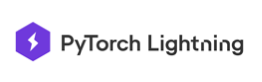


# Full Implementation

So, the full implementation is as follows.


In [ ]:
!pip install lightning-bolts==0.6.0.post1
!pip install lightning-lite==1.8.0
!pip install lightning-utilities==0.3.0
!pip install pytorch-lightning==1.8.0

In [4]:
import pl_bolts

ImportError: cannot import name 'LightningLoggerBase' from 'pytorch_lightning.loggers' (c:\Users\Usama\anaconda3\envs\quant\lib\site-packages\pytorch_lightning\loggers\__init__.py)

In [1]:
import torch
import numpy as np
import PIL.Image
# import matplotlib.pyplot as plt
class DivideIntoPatches:
    def __init__(self, patch_size):
        self.patch_size = patch_size

    def __call__(self, img):
        height, width = img.shape[-2:]
        patches = []
        for i in range(0, height - self.patch_size + 1, self.patch_size):
            for j in range(0, width - self.patch_size + 1, self.patch_size):
                patches.append(img[ :, i:i + self.patch_size, j:j + self.patch_size])
        return torch.stack(patches, dim=0)

In [4]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)
import torch

class AE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=512, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(latent_dim=latent_dim,
                                        input_height=input_height,
                                        first_conv=False,
                                        maxpool1=False)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def training_step(self, batch, batch_idx):
        # print(batch)
        x, _ = batch
        #if channels are less than 3, repeat channels
        if x.shape[0] < 3:
            print(x.shape)
            x = x.repeat(3, 1, 1)
            print(x.shape)
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        # print(x.shape,x_encoded.shape)
        # x_encoded = self.fc_mu(x_encoded)

        x_hat = self.decoder(x_encoded)
        # print(x_hat.shape)

        # reconstruction loss
        recon_loss_ = self.gaussian_likelihood(x_hat, self.log_scale, x) # old recon_loss 
        # print(recon_loss.shape)
        # recon_loss = torch.nn.MSELoss()(x_hat,x,reduction='mean')
        recon_loss = F.mse_loss(x, x_hat, reduction="none")
        recon_loss = recon_loss.sum(dim=[1, 2, 3]).mean(dim=[0])
       
       
        # print(recon_loss.shape)
        # elbo =recon_loss_
        loss = (-recon_loss_.mean() + recon_loss)
        self.log_dict({
            'reconstruction': loss,
        })

        return loss

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()
        self.input_height = input_height

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(latent_dim=latent_dim,
                                        input_height=input_height,
                                        first_conv=False,
                                        maxpool1=False)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu),
                                       torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        # print(batch)
        x, _ = batch
        #if channels are less than 3, repeat channels
        # print(x.shape)
        # if x.shape[1] < 3:
        #     x = x.repeat(1, 3, 1, 1)
        if x.dim() >3: # b,16,3,h,w -> b*16,3,h,w
            x = x.view(-1, x.shape[2], x.shape[3], x.shape[4])
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss_ = self.gaussian_likelihood(x_hat, self.log_scale, x) # old recon_loss 
        # print(recon_loss.shape)
        recon_loss = torch.nn.MSELoss()(x_hat,x)
        # print(recon_loss.shape)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss_) # with old recon_loss
        # elbo = (kl + recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss_': recon_loss.mean(),
            'recon_loss': recon_loss_.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        #if channels are less than 3, repeat channels
        # print(x.shape)
        # if x.shape[1] < 3:
        #     x = x.repeat(1, 3, 1, 1)
        # print(x.shape)
        if x.dim() >3: # b,16,3,h,w -> b*16,3,h,w
            x = x.view(-1, x.shape[2], x.shape[3], x.shape[4])
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded

        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss_ = self.gaussian_likelihood(x_hat, self.log_scale, x)
        # print(recon_loss.shape)
        recon_loss = torch.nn.MSELoss()(x_hat,x)


        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss_) # with old recon_loss
        # elbo = (kl + recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'val_elbo': elbo,
            'val_kl': kl.mean(),
            'val_recon_loss_': recon_loss.mean(),
            'val_recon_loss': recon_loss_.mean(),
            'val_reconstruction': recon_loss.mean(),
            'val_kl': kl.mean(),
        })

        return elbo
            

ModuleNotFoundError: No module named 'pl_bolts'

Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test


In [19]:
import torch.utils.data as data
import numpy as np
import datetime
from os import listdir
import random
from os.path import join
from os.path import basename
from PIL import Image
import h5py

class wss_dataset_class(data.Dataset):
    def __init__(self,
                 root_dir,
                 split,
                 transform=None,
                 preload_data=False,
                 train_pct=0.8,
                 balance=True):
        super(wss_dataset_class, self).__init__()
        #train dir
        img_dir = root_dir

        self.image_filenames = sorted(
            [join(img_dir, x) for x in listdir(img_dir) if is_image_file(x)])
        self.target_filenames = [
            list(
                map(int, [
                    x.split('-')[-1][:-4][1],
                    x.split('-')[-1][:-4][4],
                    x.split('-')[-1][:-4][7]
                ])) for x in self.image_filenames
        ]
        sp = self.target_filenames.__len__()
        sp = int(train_pct * sp)
        # random.shuffle(self.image_filenames)
        if split == 'train':
            self.image_filenames = self.image_filenames[:sp]
        elif split == 'all':
            self.image_filenames = self.image_filenames
        else:
            self.image_filenames = self.image_filenames[sp:]
            # find the mask for the image
            self.target_filenames = self.target_filenames[sp:]
            print(len(self.target_filenames))
        print('Number of {0} images: {1} patches'.format(
            split, self.__len__()))
        assert len(self.image_filenames) == len(self.target_filenames)

        # report the number of images in the dataset

        # data augmentation
        self.transform = transform

        # data load into the ram memory
        self.preload_data = preload_data
        if self.preload_data:
            print('Preloading the {0} dataset ...'.format(split))
            self.raw_images = [
                open_image_np(ii)[0] for ii in self.image_filenames
            ]
            print('Loading is done\n')

    def __getitem__(self, index):
        # update the seed to avoid workers sample the same augmentation parameters
        np.random.seed(datetime.datetime.now().second +
                       datetime.datetime.now().microsecond)
        target = self.target_filenames[index]
        if sum(target) == 2:
            target = 0#3
        else:
            target = np.array(target).argmax()
        # load the nifti images
        if not self.preload_data:
            input = open_image_np(self.image_filenames[index])
        else:
            input = np.copy(self.raw_images[index])

        # handle exceptions
        if self.transform:
            input = self.transform(input)

        return input, target

    def __len__(self):
        return len(self.image_filenames)


def is_image_file(filename):
    return any(
        filename.endswith(extension)
        for extension in [".nii.gz", 'png', 'tiff', 'jpg', "bmp"])


def open_image(filename):
    """
    Open an image (*.jpg, *.png, etc).
    Args:
    filename: Name of the image file.
    returns:
    A PIL.Image.Image object representing an image.
    """
    image = Image.open(filename)
    return image


def open_image_np(path):
    im = open_image(path)
    array = np.array(im)
    return array
class HDF5Dataset(data.Dataset):
    """
    Load an HDF5 dataset.
    Args:
    path_train: Path to the HDF5 file.
    path_train_y: Path to the HDF5 file labels.
    transform
    """
    def __init__(self, path,path_y, transform=None, limit=False):
        super(HDF5Dataset, self).__init__()
        self.path = path
        self.path_y = path_y
        self.limit = limit
        self.transform = transform
    def __getitem__(self, index):
        with h5py.File(self.path, 'r') as hf:
            input = hf['x'][index]
        with h5py.File(self.path_y, 'r') as hf:
            target = hf['y'][index].squeeze()
        if self.transform:
            input = self.transform(input)
        return input, torch.tensor(target)
    def __len__(self):
        if self.limit is not False:
            return self.limit
        with h5py.File(self.path, 'r') as hf:
            return len(hf['x'])

In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader
patch_size = 112
img_size = 224
num_patches = (img_size // patch_size) ** 2
bs = 90 // num_patches
if num_patches <5:
    bs=bs//2
print("config:\n", "patch_size:", patch_size, "img_size:", img_size, "num_patches:", num_patches, "bs:", bs)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float),
    DivideIntoPatches(patch_size=patch_size), # takes an image tensor and returns a list of patches stacked as (H // patch_size **2 x H x W x C)
    ])
# data = wss_dataset_class("/home/uz1/data/wsss/train/1.training", 'all',
                        #  transform)
# data = HDF5Dataset("/home/uz1/DATA!/pcam/pcam/training_split.h5","/home/uz1/DATA!/pcam/Labels/Labels/camelyonpatch_level_2_split_train_y.h5",transform=transform)
from medmnist.dataset import PathMNIST, BreastMNIST,OCTMNIST,ChestMNIST,PneumoniaMNIST,DermaMNIST,RetinaMNIST,BloodMNIST,TissueMNIST,OrganAMNIST,OrganCMNIST,OrganSMNIST
# using a unified ataset of medmnist
from datasets import combined_medinst_dataset
data = PathMNIST(root='/home/uz1/DATA!/medmnist', split='train',transform=transform)
loader = DataLoader(data, batch_size=bs, drop_last=True, num_workers=16)


config:
 patch_size: 112 img_size: 224 num_patches: 4 bs: 11


In [21]:
next(iter(loader))[0].shape # a batch is (batch_size, num_patches, C, H , W)

torch.Size([11, 4, 3, 112, 112])

/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


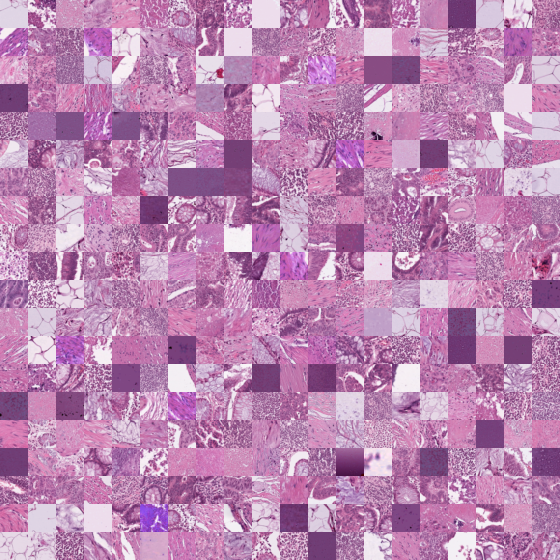

In [22]:
data.montage()

In [23]:
# val_data = wss_dataset_class("/home/uz1/data/wsss/train/1.training",
                                    # 'valid', transform)
val_data= PathMNIST(root='/home/uz1/DATA!/medmnist', download=True,split='val',transform=transform)
val_loader = DataLoader(val_data, batch_size=bs, drop_last=True, num_workers=16)
len(val_data)

Using downloaded and verified file: /home/uz1/DATA!/medmnist/pathmnist.npz


10004

In [24]:
#`` lr logging
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from callbacks import  TestReconCallback_vae,TestReconCallback_ae
import os
import random
import datetime

callbacks = []
lr_monitor = LearningRateMonitor(logging_interval="epoch")
callbacks.append(lr_monitor)

# save checkpoint on last epoch only
ckpt = ModelCheckpoint(f"/home/uz1/projects/GCN/logging/{data.__class__.__name__}/{datetime.datetime.now().strftime('%Y_%m_%d')}",
                       monitor="elbo",
                       save_weights_only=True)
callbacks.append(ckpt)

# add test for mid-train recon viewing
test = [data[x][0] for x in random.sample(range(len(data)), 1)]

test = torch.stack(test, 0).squeeze()
testRecon = TestReconCallback_vae(test)
callbacks.append(testRecon)
# 

In [25]:
pl.seed_everything(1234)

vae2 = VAE(input_height=data[0][0].shape[2], latent_dim=256)
print("Using input shape: ", data[0][0].shape, " latent dim: ", 256)
# model = deeplab(args={'n_channel': 3, 'n_classes': 2})
trainer = pl.Trainer(gpus=1,
                     max_epochs=500,
                    #  progress_bar_refresh_rate=10,
                     
                     callbacks=callbacks,strategy="dp")
vae = vae2.load_from_checkpoint("/home/uz1/projects/GCN/logging/PathMNIST/epoch=7-step=89992.ckpt",)
vae.decoder.upscale1.size =  vae2.decoder.upscale1.size
print("upscale size : ",vae.decoder.upscale1.size, " - transfering from input hieght : ",vae.input_height)
# vae2.cuda()
# vae.encoder = vae2.encoder
# vae/.encoder = vae2.encoder

trainer.fit(vae, loader,val_loader)


Global seed set to 1234
/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:80: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [2, 2, 2, 2], first_conv, maxpool1)
/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packag

Using input shape:  torch.Size([4, 3, 112, 112])  latent dim:  256
/applications/slurm-22.05.2/bin/srun


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:80: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/pl_bolts/models/autoencoders/components.py:334: UnderReviewWarning: The feature ResNetEncoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  return ResNetEncoder(EncoderBlock, [

upscale size :  14  - transfering from input hieght :  32
/applications/slurm-22.05.2/bin/srun


/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/lightning_lite/plugins/environments/slurm.py:172: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/uz1/miniconda3/envs/ML/lib/python3.7/site-pack ...
  category=PossibleUserWarning,
/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:606: UserWarning: Checkpoint directory /home/uz1/projects/GCN/logging/PathMNIST/2023_03_12 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
---------------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/uz1/miniconda3/envs/ML/lib/python3.7/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
import torch
import os

vae2 = VAE(input_height=data[0][0].shape[2], latent_dim=256)
def state_dict_compare(model1, model2):
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()
    # Compare state dictionaries
    print("Found in both")
    count = 0
    for key in state_dict1:
        #shared keys
        if key in state_dict2:
            if not torch.equal(state_dict1[key], state_dict2[key]):
                print(f"Not equal - Key: {key}\nModel 1: {state_dict1[key].shape}\nModel 2: {state_dict2[key].shape}\n")
        else:
            #keys in model1 but not model2
            print(f"Key: {key}\nModel 1: {state_dict1[key]}\nModel 2: None\n")
            count += 1
    print("number of keys in model1 but not model2: ", count)
state_dict_compare(vae.decoder.cpu(), vae2.decoder.cpu())

Now we train!


In [12]:

vae = vae.load_from_checkpoint("/home/uz1/projects/GCN/logging/PathMNIST/epoch=7-step=89992.ckpt",)
vae2 = VAE(input_height=data[0][0].shape[2], latent_dim=256)
print(vae.input_height,), print(vae2.input_height)



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_3909614/1230187850.py:1 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3909614/1230187850.py'                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'vae' is not defined

In [ ]:

model = deeplab(args={'n_channel': 3, 'n_classes': 2})
# vae = model.load_from_checkpoint("/home/uz1/projects/GCN/logging/PathMNIST/epoch=244-step=172234.ckpt")
vae = model.load_from_checkpoint("/home/uz1/projects/GCN/logging/DermaMNIST/epoch=378-step=10232.ckpt")

In [ ]:

vae = VAE(input_height=data[0][0].shape[2], latent_dim=256)
# vae = vae.load_from_checkpoint("/home/uz1/projects/GCN/logging/epoch=128-step=45278.ckpt") # pathmnist
# vae = vae.load_from_checkpoint("/home/uz1/projects/GCN/logging/DermaMNIST/epoch=378-step=10232.ckpt") # derma
vae = vae.load_from_checkpoint("/home/uz1/projects/GCN/logging/PathMNIST/2023_02_18/epoch=9-step=74990.ckpt") # bloodmnist

## Plot an image


In [ ]:
vae.decoder(vae.encoder(data[0][0].cuda())).shape

output of model embeddings z shape:  torch.Size([16, 256])


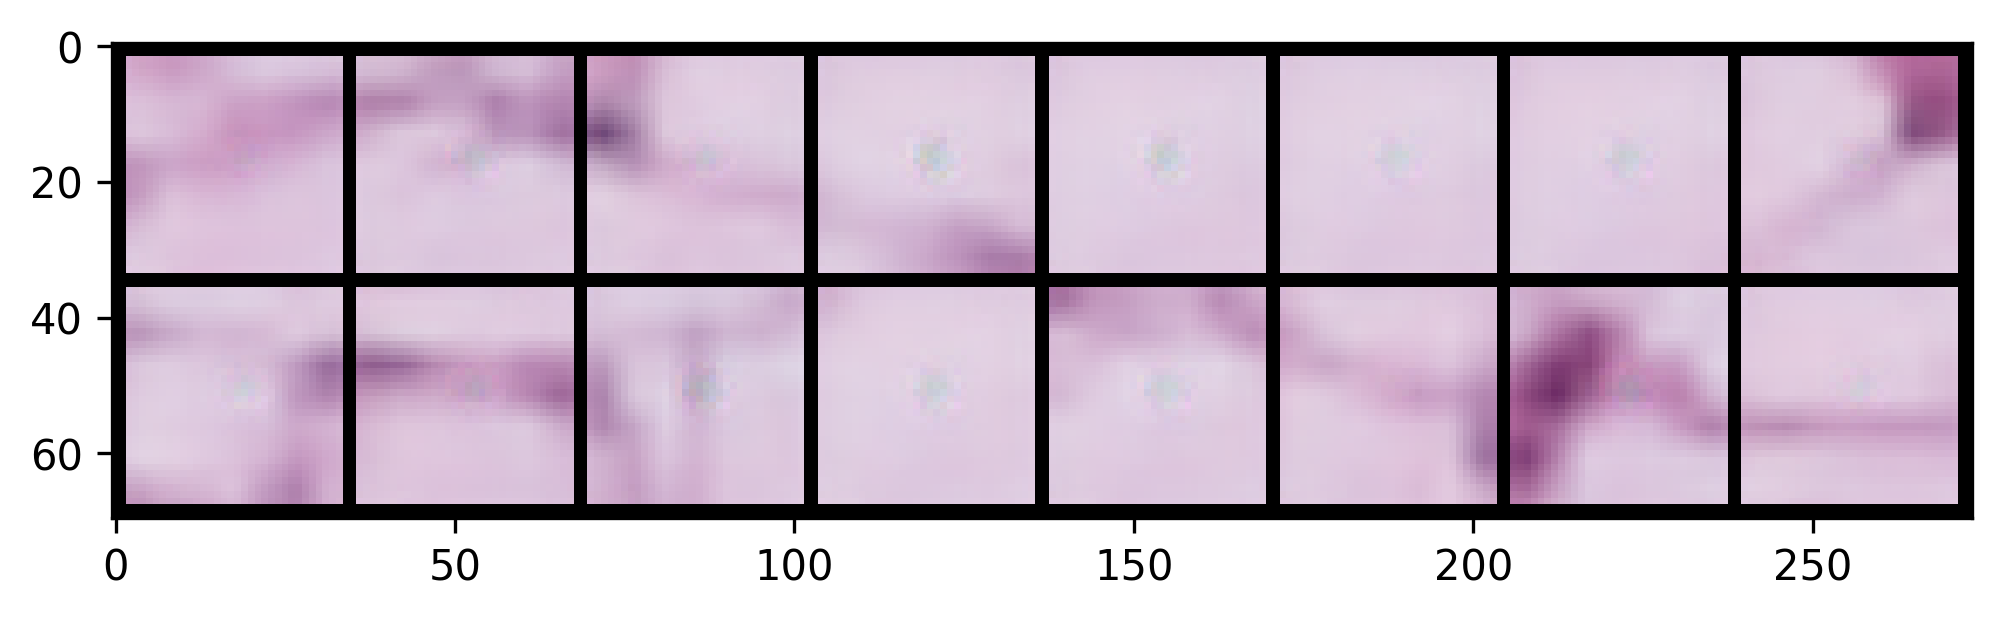

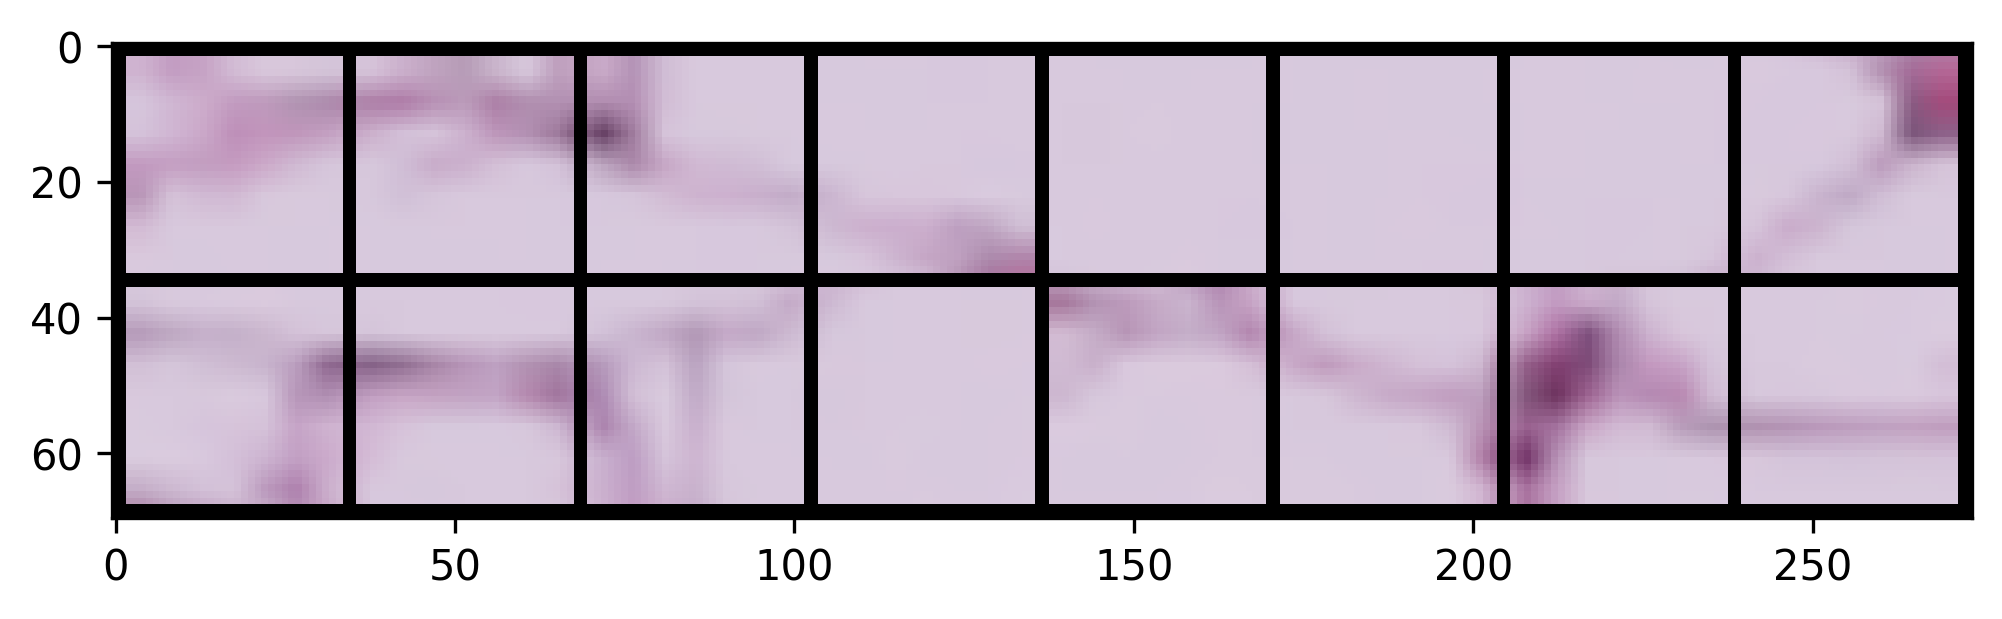

In [11]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

figure(figsize=(8, 3), dpi=300)
# real teest data
num_preds = 16
# test = [data[x][0] for x in range(num_preds)]

if data[0][0].dim() > 3:
    test = [data[x][0] for x in random.sample(range(len(data)), 1)]
    # test = test[0]
else:
    test = [data[x][0] for x in random.sample(range(len(data)), num_preds)]

test = torch.stack(test, 0).to(vae.device).squeeze()
if vae.__class__.__name__ == "VAE":
    # if chnnels are 1, then we repeat it 3 times
    if test.shape[1] == 1:
        test = test.repeat(1, 3, 1, 1)
    x_encoded = vae.encoder(test)

    mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
    std = torch.exp(log_var / 2)
    # Z COMES FROM NORMAL(0, 1)
    p = torch.distributions.Normal(mu, std)
    z = p.rsample()

    print("output of model embeddings z shape: ", z.shape)
    # SAMPLE IMAGES
    with torch.no_grad():
        pred = vae.decoder(z.to(vae.device)).cpu()
elif vae.__class__.__name__ == "deeplab":
    with torch.no_grad():
        pred = vae(test).cpu()
    
# UNDO DATA NORMALIZATION
# normalize = cifar10_normalization()
# mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).cpu().numpy() * 1  # std + mean

# PLOT IMAGES
imshow(img)

figure(figsize=(8, 3), dpi=300)
img_ = make_grid(test).permute(1, 2, 0).cpu().numpy() * 1  # std + mean
imshow(img_)

In [ ]:
#view samples in test set
img = make_grid(test).permute(1, 2, 0).cpu().numpy() * 1  # std + mean
imshow(img)


In [ ]:
from torchvision.transforms import ToPILImage

pil = ToPILImage()

#random sampling from latent space  - random points from space
figure(figsize=(8, 3), dpi=300)
mu = torch.rand((16, 512))
std = torch.rand((16, 512))
p = torch.distributions.Normal(mu, std)
z = p.rsample()
img = vae.decoder(z.to(vae.device)).cpu()

img = make_grid(img).permute(1, 2, 0).numpy() * 1  # std + mean
imshow(img)

In [ ]:
#random sampling from latent space - from same distribution get N samples
figure(figsize=(8, 3), dpi=300)
mu = torch.rand((1, 512))
std = torch.rand((1, 512))
p = torch.distributions.Normal(mu, std)
z = p.rsample((16, ))
img = vae.decoder(z.to(vae.device)).cpu()

img = make_grid(img).permute(1, 2, 0).numpy() * 1  # std + mean
imshow(img)

In [ ]:
import matplotlib.pyplot as plt

num_points = 1000
# real test data  -  vis of means of data and class clusters
# test = [data[x][0] for x in range(num_points)]
# y_test = [data[x][1] for x in range(num_points)]
test = [[data[x][0], data[x][1]] for x in random.sample(range(len(data)), num_points)]
y_test = [x[1] for x in test]
test = [x[0] for x in test]
test = torch.stack(test, 0).to(vae.device)
x_encoded = vae.encoder(test)

mu, _ = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
mu = mu.detach().cpu().numpy()
# std = torch.exp(log_var / 2

#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

In [ ]:
# Display a 2D manifold of the digits
n = 8  # figure with 30x30 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

x = data[2][0].unsqueeze(0)
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2).detach().cpu()
mu = mu.detach().cpu()

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = torch.tensor(np.linspace(mu, mu, n))
grid_y = torch.tensor(np.linspace(std, std, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        # z_sample = np.array([[xi, yi]])
        # print(xi.shape,yi.shape)
        # Generate an image using a decoder model
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        x_decoded = vae.decoder(z).detach().cpu().numpy()
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker

        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded.reshape(digit_size, digit_size, 3)

        figure[i * digit_size:(i + 1) * digit_size, j * digit_size:(j + 1) *
               digit_size] = digit[:, :, :1].squeeze()

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()

In [ ]:
torch.distributions.Normal(torch.tensor(xi), torch.tensor(yi))


In [ ]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = data[1][0].unsqueeze(0)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

In [ ]:
trainer.save_checkpoint("/home/uz1/projects/GCN/logging/final.cpkt")

In [ ]:
len(data)

# K-Means!


In [29]:
num_points = 700 if len(data) > 20000 else len(data)
# real test data  -  vis of means of data and class clusters
# test = [data[x][0] for x in range(num_points)]
# y_test = [data[x][1] for x in range(num_points)]
# print([x for x in random.sample(range(len(data)), num_points)])
# get test amd y_test wiht random num_points (use a random sample of data) - same for both 
vae = vae.to('cpu')
if data[0][0].dim() > 1:
    test = [data[x][0] for x in random.sample(range(len(data)), num_points)]
else:
    test = [[data[x][0],data[x][1]] for x in random.sample(range(len(data)), num_points)]
# y_test= [x[1] for x in test]

test = torch.stack(test, 0).to(vae.device)
if test.dim() >4:
    test = test.reshape(-1, test.shape[2], test.shape[3], test.shape[4])
print(test.shape)
if vae.__class__.__name__ == 'VAE':
    x_encoded = vae.encoder(test)

    mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    z=z.detach().cpu().numpy()
    print("Done - out shape ",z.shape)
elif vae.__class__.__name__ == 'deeplab':
    z = vae.encode(test)[0].detach().cpu().numpy()

torch.Size([11200, 3, 32, 32])
Done - out shape  (11200, 256)


In [ ]:

k = AgglomerativeClustering(n_clusters = 16, affinity = 'euclidean', linkage ='ward').fit(z)


In [39]:
from sklearn.cluster import KMeans
import math
import pickle
from math import sqrt
x_em = z
h=int(int(data[0][0].shape[-1]) * sqrt(data[0][0].shape[0]))
p_z = int(sqrt((h*h) // int(data[0][0].shape[0])))
print("Using a VAE with h=",h,"and p(z)=",p_z)
for n in [8,16,32,64,128]:
    k=KMeans(n_clusters=n).fit(x_em.reshape(x_em.shape[0],-1))
    k.labels_.shape 
    #count unique values + return counts
    unique, counts = np.unique(k.labels_, return_counts=True)
    print("unique values:", unique)
    print("counts:", counts)
    with open(f"kmeans-model-{h}-{p_z}-{n}-{data.__class__.__name__}.pkl", "wb") as f:
        pickle.dump(k, f)

Using a VAE with h= 128 and p(z)= 32
unique values: [0 1 2 3 4 5 6 7]
counts: [1758 1248 1625 1440 1720 1012  844 1553]
unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
counts: [815 651 754 505 768 298 658 814 485 717 909 771 858 614 776 807]
unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
counts: [151 333 441 358 336 370 356 273 359 319 192 411 376 371 445 255 491 325
 407 529 214 186 360 421 336 422 387 349 397 419 405 206]
unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
counts: [ 25  67 113 185 238 198 165  88 172 136 201 204 247 105 208 156 136 189
 218 149 294 209 118 166 214 175 141 128 185 154 146 252 207 203 169 151
 217 105 238 197 126 103 202 159 209 193 254 151 202 178 220 242 148 166
 121 241  83 177 191 205 196 163 223 178]


In [ ]:
import pickle
with open("kmeans-model-16-pathmnist.pkl", "wb") as f:
    pickle.dump(k, f)
del test


In [ ]:
import pickle

with open("kmeans-model-16-pathmnist.pkl", "rb") as f:
    k = pickle.load(f)

In [ ]:
del mu
del log_var
del std
del z

In [ ]:

import pickle
with open("kmeans-model-8-medmnist-path.pkl", "rb") as f:
    k = pickle.load(f)
#loop throuhg untill no images encode then get z 
no = 2000
zs = torch.zeros((no, 1024))
labels = []
for i in range(no):
    x = data[i][0].unsqueeze(0)
    x_encoded = vae.encoder(x)
    mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
    std = torch.exp(log_var / 2)
    q = torch.distributions.Normal(mu, std)
    z = q.rsample()
    # print(z.shape)
    l = k.predict(z.detach().cpu().numpy())
    # print(l)
    zs[i] = z
    labels.append([l, data[i][1]])
print(zs.shape)
print(len(labels))
print(labels[0][0])

In [ ]:
del zs,labels

In [ ]:
# labels = [[x[0][0],x[1][0]] for x in labels]
# labels_ = ["{}{}".format(x[0][0],x[1][0]) for x in labels]
labels_ = [x[1][0] for x in labels]

#count how many of each class 
counter = np.zeros((16,len(labels_)))
for x in range(len(label)):
    # print(x)
    # print(label[x])
    counter[label[x],x] += 1
counter
#add labels_ to counter
counter = np.vstack((counter,labels_))
counter.shape

In [ ]:
#build correclatoin df between labels from kmeans and labels from data
import pandas as pd
import seaborn as sns
df = pd.DataFrame(np.transpose(test), columns=["C_{}".format(x) for x in range(label.n_clusters_)]+["label"])
print(df.head())
sns.set(rc = {'figure.figsize':(35,16)})
map = sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [ ]:
from sklearn.cluster import AgglomerativeClustering,FeatureAgglomeration
model = FeatureAgglomeration(distance_threshold = 40, affinity = 'euclidean', linkage ='ward',n_clusters=None)#thresh here from the diagram belwo
label = model.fit(z[:100])
label.n_clusters_

In [ ]:
model.n_connected_components_

In [ ]:
test= label.transform(zs.detach().numpy())
test = np.vstack((np.transpose(test),labels_))

In [ ]:
labels_ = ["{}{}".format(x[0][0],x[1][0]) for x in labels]

In [ ]:
temp[2]

In [ ]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt

# Generate random features and distance matrix.
temp = hierarchy.linkage(z, 'ward',metric='euclidean')
plt.figure(figsize=(35, 20))
 
dn = hierarchy.dendrogram(
    temp, above_threshold_color="red", color_threshold=45, leaf_font_size=10, leaf_rotation=90)

In [ ]:
from torch.utils.tensorboard.writer import SummaryWriter
writer = SummaryWriter("/home/uz1/projects/GCN/lightning_logs")
import datetime

now = datetime.datetime.now()

current_time = now.strftime("%H:%M:%S")
writer.add_embedding(zs[:6000],labels[:6000],global_step=current_time)

In [ ]:
#Plot dim1 and dim2ss for mu

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=k.labels_, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

# Trial - Graph Foramtion - Just on Patches
#### Make a patch of orginal dimention subsampled into samller patches
#### Project these patches using VAE
#### get their assigned cluster number based on the KMeans classifier 


Also need a way to store the Kmeans classifier as a outside file to load on inference 


In [ ]:
#load images to be patched 
from torchvision import transforms
from torch.utils.data import DataLoader
## images as 128x128 to 16 patches (each 32x32)
im_size=128
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomResizedCrop((128,128)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((im_size,im_size)),
])
data_128 = wss_dataset_class("/home/uz1/data/wsss/train/1.training", 'all',
                         transform)
data_128 = data
data_128.transform = transform
data_128.limit=30000
loader = DataLoader(data_128, batch_size=32, drop_last=True, num_workers=16)






In [ ]:
len(data_128)

In [ ]:
from torchvision.transforms import ToPILImage,ToTensor
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from skimage import graph, io, segmentation, color
from matplotlib import pyplot as plt
import pickle
from torch_geometric.utils import to_dense_adj, grid,dense_to_sparse
from monai.data import GridPatchDataset, DataLoader, PatchIter
patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
#patching each image
with open("kmeans-model-32-PathMNIST.pkl", "rb") as f:
    k = pickle.load(f)
pil = ToPILImage()
to_tensor=ToTensor()
patches = []
coords=[]
#pick a random number
# n=np.random.randint(0,len(data_128))
n=119
#iterate over image patches 
img=data_128[n][0]
# z = zs[n]
print("target = ",data_128[n][1])
for x in patch_iter(img):
	patches.append(x[0])
	coords.append(x[1])


def get_embedding_vae(x,vae):

	if vae.__class__.__name__ == "VAE":
		x_encoded = vae.encoder(x)
		mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
		std = torch.exp(log_var / 2)
		q = torch.distributions.Normal(mu, std)
		z = q.rsample()
		return z 
	elif vae.__class__.__name__ == "deeplab":
		x = vae.encode(x)
		return x[0].reshape(x[1].shape[0],-1)
	else:
		raise ValueError("vae must be either VAE or deeplab - got {}".format(vae.__class__.__name__))

patches = torch.stack([torch.tensor(patches)],0).squeeze()
print("patches shape = ",patches.shape)
#embed using model 
z=get_embedding_vae(patches,vae).detach().cpu().numpy()
	#kmean cluster find 
print("embed shape = ",z.shape)
label = k.predict(z)# B,d

#show patches grid
# img = make_grid(patches,nrow = 4).permute(1, 2, 0).numpy()
# imshow(img)




labels_ = np.zeros((im_size,im_size))
#generate label map for whole image 
for l, coord in zip(label,coords):
	labels_[coord[1][0]:coord[1][1],coord[2][0]:coord[2][1]] = l

img = np.array(pil(img))
label_rgb = color.label2rgb(labels_, img, kind='overlay')
# imshow(label_rgb)

imgs = torch.stack([to_tensor(img),to_tensor(label_rgb)],0)
img = make_grid(imgs,nrow = 4).permute(1, 2, 0).numpy()
imshow(img),label.reshape(int(im_size/32),int(im_size/32))

In [ ]:
patches[1].shape

In [ ]:
from math import sqrt
sqrt(9)

In [ ]:
def populateS(labels,n_clusters=16,s=None):
    """"
    Calculates the S cluster assigment transform of input patch features 
    and returns the (S) and the aggregated (out_adj) as well.
    shape : ( number of patches , number of clusters)
    """
    # print("S is " ,s==None)
    n_patches=len(label)
    div = int(sqrt(n_patches))
    if s == None: 
        s = np.zeros((n_patches,n_clusters))
        for i in range(s.shape[0]):
            s[i][labels[i]] = 1
    else:
        s=s
    
    #calc adj matrix
    adj = to_dense_adj(grid(n_patches//div,n_patches//div)[0]).reshape(n_patches,n_patches)
    return s , np.matmul(np.matmul(s.transpose(1, 0),adj ), s)
s ,out_adj= populateS(label)
zz=np.matmul(s.transpose(1,0) , z)

In [ ]:
out_adj.div(out_adj.sum(1)),out_adj # for each cluster - the row describes how for the cluster - How many times it was adjacent to the other clusters 

In [ ]:
dense_to_sparse(out_adj)[0].reshape(43,-1)

In [ ]:
np.unique(label)

In [ ]:
zz.shape

In [ ]:
s,zz[3]

In [ ]:
to_dense_adj(grid(4,4)[0]).shape

In [ ]:
adj = to_dense_adj(grid(16,16)[0]).reshape(64,64)
out_adj =np.matmul(np.matmul(s.transpose(1, 0),adj ), s)

In [ ]:
def calculate_cluster_dist_stat(label):
    s = torch.zeros(16,8)   
    label=label+1
    l=label.copy()
    for i in range(16):
        print(label.reshape(4,4))
        l[i]=0
        unique_n = torch.unique(a[i].reshape(4,4) * l.reshape(4,4),return_counts=True)
        no_n = sum(unique_n[1][1:])
        print(torch.unique(a[i].reshape(4,4) * l.reshape(4,4),return_counts=True) ,no_n,l[i],)
        perc_n = unique_n[1][1:]/no_n

        w = torch.zeros(8,)
        w[unique_n[0][1:].long()-1] = perc_n
        s[i] = w
    return s
calculate_cluster_dist_stat(label)


In [ ]:
print("embedding shape: ",z.shape)
img = vae.decoder(to_tensor(z).squeeze())
print("Output of decoder shape: ",img.shape)

img = make_grid(img,nrow = 4).permute(1, 2, 0).numpy()
imshow(img)

In [ ]:
import numpy as np

from monai.data import GridPatchDataset, DataLoader, PatchIter

#patch yeilding 



# image-level dataset
images = data_128
# image-level patch generator, "grid sampling"
patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
# patch-level intensity shifts
# patch_intensity = RandShiftIntensity(offsets=1.0, prob=1.0)

# construct the dataset
ds = GridPatchDatasetWithLabels(data=images,
                      patch_iter=patch_iter,)
# use the grid patch dataset
# for item in DataLoader(ds, batch_size=2, num_workers=2):
#     print("patch size:", item[0].shape)
#     print("coordinates:", item[1])

# >>> patch size: torch.Size([2, 1, 2, 2])
#     coordinates: tensor([[[0, 1], [0, 2], [0, 2]],
#                          [[0, 1], [2, 4], [0, 2]]])

In [ ]:

# Install required packages.
import os
import torch 
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

from torch_geometric.data import Data,Dataset

def visualize_graph(G, pos,nodelist=None,edgecolor=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, with_labels=True,
                      cmap="viridis",  node_size=200,nodelist = nodelist,edge_color=edgecolor,edge_vmin=0,edge_vmax=10)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16,color='white')
    plt.show()
pos_dict = {e:[k,v] for e,(k,v) in enumerate(grid(3,3)[1])}


# data=train_dataset[2]
d= Data(x=zz,edge_index=dense_to_sparse(out_adj)[0],edge_attr=dense_to_sparse(out_adj)[1])
G = to_networkx(d, to_undirected=False)
visualize_graph(G, pos=pos_dict,nodelist=list(torch.unique(d.edge_index[0]).numpy()),edgecolor=list(d.edge_attr.numpy())) 

In [ ]:
dense_to_sparse(out_adj)[1],dense_to_sparse(out_adj)[0]

## Build a GCN 
#### Cluster assignment given using the KMEANS + edge features (statistics !?)
#### pool features using the assignmentinto cluster node features 
#### build and classify images  - somehow 	

In [ ]:
from tkinter import Label
from monai.data.iterable_dataset import IterableDataset
from monai.transforms import apply_transform
import numpy as np

from monai.data import GridPatchDataset, DataLoader, PatchIter

#patch yeilding 



# image-level dataset
images = data_128
# images = medmnist
# image-level patch generator, "grid sampling"
patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
# patch-level intensity shifts
# patch_intensity = RandShiftIntensity(offsets=1.0, prob=1.0)


class GridPatchDatasetWithLabels(IterableDataset):

    """
    Takes a list or Dataset of iamges and their labels 
    returns:
    Patchs , coords, image label
    """
    def __init__(
        self,
        data ,
        patch_iter ,
        transform=None,
        with_coordinates=True,
        kmeans=None,
    ) -> None:
        super().__init__(data=data, transform=None)
        self.patch_iter = patch_iter
        self.patch_transform = transform
        self.with_coordinates = with_coordinates

    def __iter__(self):
        for  image,label in super().__iter__():
            for patch, *others in self.patch_iter(image):
                out_patch = patch
                if self.patch_transform is not None:
                    out_patch = apply_transform(self.patch_transform, patch, map_items=False)
                if self.with_coordinates and len(others) > 0:  # patch_iter to yield at least 2 items: patch, coords
                    yield torch.tensor(out_patch), others[0],label
                else:
                    yield torch.tensor(out_patch),label
    
    def __getitem__(self, index):
        patches=[]
        coords=[]
        for patch,coord in self.patch_iter(self.data[index][0]):
            out_patch = patch
            if self.patch_transform is not None:
                out_patch = apply_transform(self.patch_transform, patch, map_items=False)
            patches.append(out_patch)
            coords.append(coord)
        return torch.stack([torch.tensor(patches)],0),coords,self.data[index][1]
                
# construct the dataset
ds = GridPatchDatasetWithLabels(data=images,
                      patch_iter=patch_iter,)

In [ ]:
def get_embedding_vae(x,vae):

	x_encoded = vae.encoder(x)
	mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)
	std = torch.exp(log_var / 2)
	q = torch.distributions.Normal(mu, std)
	z = q.rsample()
	return z
#generate an embedding for each image in dataset 
zs=[]
labels =[]
for patches,coords,label in DataLoader(ds, batch_size=16, num_workers=8):
# for patches,coords,label in ds:
	# print(patches.shape,coords,label)
	z=get_embedding_vae(patches,vae).detach().cpu().numpy()
	label=k.predict(z)
	zs.append(z)	
	labels.append(label)	


print(len(zs),len(labels))


	

In [ ]:
zss=torch.stack([torch.tensor(zs)],0)

In [ ]:
labels = np.array(labels)

In [ ]:
zs = zss.reshape(-1,16,1024)

In [ ]:
import h5py

ff = h5py.File('data1.h5', 'w')
N = zs.shape[0]
z=ff.create_dataset('zs', shape=(N, 16,1024), dtype=np.float32, fillvalue=0) #z
z=zs.numpy()
l=ff.create_dataset('labels', shape=(N, 16, ), dtype=np.float32, fillvalue=0) #labels
l=labels
print(z.shape,l.shape)
ff.close()

In [ ]:
import h5py
ff = h5py.File('data1.h5', 'r')
zss = ff['zs']

In [ ]:
# The GCN process
'''

A gcn takes input the following:

features matrix N,F
adj Matrix N,D,D
Edge features ? - 

'''
from math import sqrt
def populateS(labels,n_clusters=8,s=None):
    """"
    Calculates the S cluster assigment transform of input patch features 
    and returns the (S) and the aggregated (out_adj) as well.
    shape : ( number of patches , number of clusters)
    """
    # print("S is " ,s==None)
    n_patches=len(label)
    div = int(sqrt(n_patches))
    if s == None: 
        s = np.zeros((n_patches,n_clusters))
        for i in range(s.shape[0]):
            s[i][labels[i]] = 1
    else:
        s=s
    
    #calc adj matrix
    adj = to_dense_adj(grid(n_patches//div,n_patches//div)[0]).reshape(n_patches,n_patches)
    return s , np.matmul(np.matmul(s.transpose(1, 0),adj ), s)

In [ ]:

from torch_geometric.data import Data,Dataset
from torch_geometric.utils import to_dense_adj, grid,dense_to_sparse
from torch_geometric.loader import DataLoader 
# print("No embeddings : ",z.shape)
# print("No data: ",len(data_128))

print(Data(x=z[1],edge_index = grid(16,16)[0],pos=grid(16,16)[1]))

def filter_a(data):

    if data.y==3:
        return False
    else:
        True

class ImageTOGraphDataset(Dataset):
    """ 
    Dataset takes holds the kmaens classifier and vae encoder. On each input image we encode then get k mean label then formulate graph as Data object
    """
    def __init__(self,data,vae,kmeans):
        self.data=data
        self.vae=vae
        self.kmeans=kmeans
        self.patch_iter = PatchIter(patch_size=(32, 32), start_pos=(0, 0))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        
        patches = []
        for x in self.patch_iter(self.data[index][0]):
            patches.append(x[0])
            
        patches = torch.stack([torch.tensor(patches)],0).squeeze()

        z=get_embedding_vae(patches,self.vae).clone().detach().cpu().numpy()
        label=self.kmeans.predict(z)
        s,out_adj = populateS(label)
        x = np.matmul(s.transpose(1,0) , z)
        return Data(x=torch.tensor(x).float(),edge_index=dense_to_sparse(out_adj)[0],y=torch.tensor(self.data[index][1]),edge_attr=dense_to_sparse(out_adj)[1])

class KDataset(Dataset):
    
    """
    Dataset to store the cluster repr of images as embedding feature maps 
    and edge as a grid formation ? - not really we use cluster feature relations as a 

    """

    def __init__(self,zs,data_128,labels,root=None,transform=None,pre_transform=None,pre_filter=None):
        super(KDataset,self).__init__(root,transform,pre_transform,pre_filter)
        self.zs=zs
        self.data = data_128
        self.labels = labels
    

    def __getitem__(self,index):
        
        s,out_adj = populateS(self.labels[index])
        x = np.matmul(s.transpose(1,0) , self.zs[index])

        
        return Data(x=x,edge_index=dense_to_sparse(out_adj)[0],y=torch.tensor(self.data[index][1]),edge_attr=dense_to_sparse(out_adj)[1])
    def __len__(self):
        return len(self.zs)


ImData = ImageTOGraphDataset(data=data_128,vae=vae,kmeans=k)
train_loader = DataLoader(ImData, batch_size=8, shuffle=True, num_workers=0)



In [ ]:
# if zs is defined then use it else use data_128
if zs is not None:
    k_data = KDataset(zs,data_128,labels,pre_filter=filter_a)
    from torch_geometric.loader import DataLoader
    print("No final data: ",len(k_data))

    train_loader = DataLoader(k_data, batch_size=8, shuffle=True)
    for data in train_loader:
        print(data)
        break

In [ ]:
ImData[12]

In [ ]:
import torch
from torch.nn import Linear,Sequential
from torch_geometric.nn import GCNConv,GATConv,EdgeConv,DynamicEdgeConv
from torch_geometric.nn import global_mean_pool


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
class GCN(torch.nn.Module):
    '''
    Can add edge_atttr using the second out of dense_to_sparse
    '''
    def __init__(self,n_classes=3):
        super().__init__()
        torch.manual_seed(1234)
        
        gcon = EdgeConv
        self.conv1 = gcon(Sequential(Linear(2*1024, 512)))

        self.conv2 =gcon(Sequential(Linear(2*512, 256)))#gcon(512, 256)
        self.conv3 =gcon(Sequential(Linear(2*256, 256)))#gcon(512, 256)
        self.conv4 =gcon(Sequential(Linear(2*256, 128)))#gcon(512, 256)
        self.conv5 =gcon(Sequential(Linear(2*128, 64)))#gcon(512, 256)
        self.conv6 =gcon(Sequential(Linear(2*64, 32)))#gcon(512, 256)
        self.classifier = Linear(32, n_classes)

    def forward(self, x, edge_index,batch):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        h = h.relu()
        h = self.conv4(h, edge_index)
        h = h.relu()
        h = self.conv5(h, edge_index)
        h = h.relu()
        h = self.conv6(h, edge_index)
        # h = h.tanh()  # Final GNN embedding space.
        h = global_mean_pool(h,batch)  # [batch_size, hidden_channels]

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out#, h

model = GCN(9)
print(model)

In [ ]:
str(m.model.__class__.__name__)

In [ ]:
from torch_geometric.nn.models import GraphSAGE,GAT,GIN,PNA
class GCN_model(torch.nn.Module):
    '''
    Can add edge_atttr using the second out of dense_to_sparse
    '''
    def __init__(self,n_classes=3,model=None):
        super().__init__()
        torch.manual_seed(1234)
        
        self.model = model
        self.classifier = Linear(model.out_channels, n_classes)

    def forward(self, x, edge_index,batch, **kwargs):
        h = self.model(x, edge_index, **kwargs)
        # h = h.tanh()  # Final GNN embedding space.
        h = global_mean_pool(h,batch)  # [batch_size, hidden_channels]

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out#, h
model = GAT(1024,512,6,32,dropout=0.5)
m = GCN_model(7,model)
for d in train_loader:
    print(m(d.x,d.edge_index,d.batch,edge_attr=d.edge_attr).shape)
    break

In [ ]:
model = GCN(9).cuda()
# data = k_data[0]
# print(data)
# out = model(ImData.x.float(), data.edge_index,data.batch)
# print(f'Embedding shape: {list(out.shape)}')

import time
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GraphUNet
from torch.functional import F
# model = GraphUNet(9,128,2,4,act=F.tanh)
criterion = torch.nn.CrossEntropyLoss()#torch.tensor([.2,.2,.8]))  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # Define optimizer.
data_laoder = train_loader
def train(data):
    optimizer.zero_grad()  # Clear gradients.
    # print(data)
    out = model(data.x.cuda(), data.edge_index.cuda(),data.batch.cuda())#,data.edge_weight.float())  # Perform a single forward pass.
    # print(torch.tensor(data.y).shape)
    loss = criterion(out.softmax(-1), data.y.cuda())  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss,out

for epoch in range(1000):
    # track using tqdm
    tqdm_bar = tqdm(data_laoder)
    losses = AverageMeter()
    acc = AverageMeter()
    for i,data in enumerate(tqdm_bar):

        loss,out = train(data)
        if i % 10 == 0:
            losses.update(loss.item())
            print(f'Epoch: {epoch}, Loss: {losses.val:.4f} ({losses.avg})')

            #calculate acc
            pred = out.softmax(-1).argmax(-1)
            accc = (pred == data.y.cuda()).float().mean()
            acc.update(accc.item())
            print(f'Accuracy: {acc.val:.4f} ({acc.avg})')
            print("Unique predictions ",np.unique(pred.cpu().detach(),return_counts=True))
            print("Unique labels ",np.unique(data.y.cpu().detach(),return_counts=True))
            # visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
            # o = Data(x=h,pos=data.pos,edge_index=data.edge_index,edge_weight=data.edge_weight,y=out.softmax(dim=-1).argmax(dim=-1))
            # G=to_networkx(o, to_undirected=True)
            # pos_dict = {e:[k,v] for e,(k,v) in enumerate(o.pos[:])}
            # visualize_graph(G, pos=pos_dict,color=o.y)
            # time.sleep(0.3)


# Data VIs


In [ ]:

#plot a csv file results as line chartts for each epoch
#load csvs files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.legend import Legend
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter
from glob import glob 
#csv paths
logs = glob("/home/uz1/projects/GCN/vae_log_*_GC*.csv") #+ ["/home/uz1/output/train/20220825-133314-pvig_s_224_gelu-500/ViG.csv"]

#load each csv data from logs
for log in logs :
    df = pd.read_csv(log)
    #change eval_top1 to val_accuracy
    df.rename(columns={'eval_top1':'val_accuracy'},inplace=True)
    df.rename(columns={'eval_loss':'val_loss'},inplace=True)
    df.rename(columns={'train_loss':'loss'},inplace=True)
    #plot loss vs epochs
    plt.figure(figsize=(10,6))
    plt.plot(df['epoch'],df['loss'],label='Loss')
    plt.plot(df['epoch'],df['val_loss'],label='Val Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epochs ({log.split("/")[-1]})')
    plt.savefig(log+'_loss.png')
    plt.show()
    plt.close()

    # plot acc vs epoch
    plt.figure(figsize=(10,6))
    plt.plot(df['epoch'],df['val_accuracy'],label='Accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs Epochs ({log.split("/")[-1]})')
    plt.savefig(log+'_acc.png')
    plt.show()
    plt.close()

In [ ]:
#plot over each other loss with file name as legend
plt.figure(figsize=(10,6))
# use plotly ?
# from plotly import g
for log in logs:
    df = pd.read_csv(log)
    # limit to 1o
    df = df[:12]
    #change eval_top1 to val_accuracy
    df.rename(columns={'eval_top1':'val_accuracy'},inplace=True)
    df.rename(columns={'eval_loss':'val_loss'},inplace=True)
    df.rename(columns={'train_loss':'loss'},inplace=True)

    # if df['val_accuracy] has values under 1 multpy the values by 100
    if df['val_accuracy'].min() < 1:
        df['val_accuracy'] = df['val_accuracy'] * 100
    plt.plot(df['epoch'],df['val_accuracy'],label=log.split("/")[-1])
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.title(f'Accuracy - ALL')
    
plt

In [ ]:

import pandas as pd
import seaborn as sns
 
df=pd.read_csv('/home/uz1/projects/GCN/clusters.csv')

df.head()
df.corr()

In [ ]:
" cluster_".join([str(i) for i in range(k.n_clusters)])

In [ ]:

import pandas as pd
import seaborn as sns
 
df=pd.read_csv('/home/uz1/projects/GCN/clusters.csv')

sns.set(rc = {'figure.figsize':(16,8)})
map = sns.heatmap(df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')
#save
map.figure.savefig("/home/uz1/projects/GCN/clusters.png")

In [ ]:
import numpy as np
kmeans = np.load('/home/uz1/saved_labels_medmnist.npy')#joblib.load(k_labels)
kmeans = kmeans.astype(np.uint8)
print("kmeans shape ",kmeans.shape)
# from datasets import combined_medinst_dataset
train_dataset = combined_medinst_dataset(root="/home/uz1/DATA!/medmnist",)
print("len of data is ",len(train_dataset))

In [ ]:
kmeans

In [ ]:


# combine multiple datasets into one Class 
from medmnist.dataset import PathMNIST, BreastMNIST,OCTMNIST,ChestMNIST,PneumoniaMNIST,DermaMNIST,RetinaMNIST,BloodMNIST,TissueMNIST,OrganAMNIST,OrganCMNIST,OrganSMNIST
from medmnist.dataset import MedMNIST2D
class combined_medinst_dataset(MedMNIST2D):
    def __init__(self, root="",split="train",transform=None,no_dataset=11,limit=None):
        # load the datasets
        self.transform =transform
        self.limit = limit
        pathmnist = PathMNIST(split=split, root=root)
        breastmnist = BreastMNIST(split=split,root=root)
        octmnist = OCTMNIST(split=split, root=root)
        chestmnist = ChestMNIST(split=split,root=root)
        pneumoniamnist = PneumoniaMNIST(split=split, root=root)
        dermamnist = DermaMNIST(split=split, root=root)
        retinamnist = RetinaMNIST(split=split, root=root)
        bloodmnist = BloodMNIST(split=split, root=root)
        organA = OrganAMNIST(split=split, root=root)
        organC = OrganCMNIST(split=split, root=root)
        organS = OrganSMNIST(split=split, root=root)
        tissueMnist = TissueMNIST(split=split, root=root,download=True)
        datasets = [pathmnist,breastmnist,octmnist,chestmnist,pneumoniamnist,dermamnist,retinamnist,bloodmnist,organA,organC,organS,tissueMnist]
        self.datasets = datasets
        self.tot  = sum(len(d) for d in self.datasets)
        if limit is not None:
            self.d = []
            ex=0
            for d in self.datasets:
                if int(limit / no_dataset) > len(d):# if the limit is greater than the dataset
                    self.d.append(len(d))
                    self.d[ex] +=(int(limit / no_dataset) - len(d))
                else:
                    self.d.append(int(limit / no_dataset))
            print("Datasets split -- > ",self.d)
        else:
            self.d = [len(d) for d in self.datasets]
        #create e dictionary mapping between the dataset index in datasets and the class index in the combined dataset
        class_index = {}
        for i,d in enumerate(datasets):
            for j in range(len(d.info['label'])):
                class_index[i,j] = sum(len(d.info['label']) for d in datasets[:i]) + j
        self.class_index = class_index
        print(self.class_index)

    def __getitem__(self, i):
        #based on i and total number of samples in all datasets, determine which dataset to get the sample from
        for y,d in enumerate(self.datasets):
            # print("looking in dataset",d," for sample",i)
            if i < self.d[y]:
                # print("Debug ----> ",i,self.d,d)
                x,z = d[i]
                if len(z) > 1:
                    z =  np.array(0) if sum(z) == 0 else np.array(1)
                # if image in index 1 has 1 channel, repeat it 3 times then reutrn it
                if x.mode == 'L':
                    return self.transform(x.convert("RGB")), self.class_index[(y,int(z))]
                return self.transform(x), self.class_index[(y,int(z))]
            i -= self.d[y]
        raise IndexError('index out of range')

    def __len__(self):
        if self.limit is not None:
            return self.limit
        #sum of all the lengths of the datasets
        return self.tot



# visualize the data using plotly 

In [ ]:
import plotly.express as px
import pandas as pd
data = pd.read_csv("")
data_by_ltyp = data.groupby(['l_typ','stage','drop','l_post']).mean().reset_index()
data_by_ltyp.head()

In [ ]:
#plot epoch vs accuracy withl_typ as color - scatterplot
fig = px.scatter(data, x="num_nodes(k)", y="Accuracy",size='num_nodes(k)')
#xaxis is dim modify layout
fig.update_layout(xaxis_title="num_nodes(k)",yaxis_title="Accuracy",title="Accuracy vs num_nodes - path ")
#modify xaxis ticks to be the same as dim
fig.update_xaxes(tickvals=data['num_nodes(k)'].unique())
#chnage theme  dark
fig.update_layout(template="ggplot2")
fig.show()

In [ ]:
# load /home/uz1/projects/GCN/GraphGym/run/results-main-deepsnap-retina/example_graph_grid_example/agg/test_best.csv 
# plot Dataset vs accuracy as barplot
import plotly.express as px
import pandas as pd
data = pd.read_csv("/home/uz1/projects/GCN/GraphGym/run/results/deepsnap-cluster-grid-path-16-16/example_graph_cluster_grid_example_cluster/agg/test_best.csv")

fig = px.bar(data, x="dataset", y="accuracy", color="dataset",barmode="group")
fig.update_layout(xaxis_title="Dataset",yaxis_title="Accuracy",title="Accuracy vs Dataset")
fig.show()

In [ ]:
'''
Load /home/uz1/projects/GCN/GraphGym/run/results-main-cluster-/example_graph_cluster_grid_example_cluster/agg/test_best.csv as baseline
and 
load 
/home/uz1/projects/GCN/GraphGym/run/results-main-deepsnap/example_graph_grid_example/agg/test_best.csv as gnncluster



'''
import plotly.express as px
import pandas as pd
data = pd.read_csv("/home/uz1/projects/GCN/GraphGym/run/results/deepsnap-cluster-grid-path-16-16/example_graph_cluster_grid_example_cluster/agg/test_best.csv")
data2 = pd.read_csv("/home/uz1/projects/GCN/GraphGym/run/results/deepsnap-cluster-grid-path-16-16/example_graph_cluster_grid_example_cluster/agg/train_best.csv")
#add a column to data2 to indicate that it is gnncluster
data2['model'] = 'train'
data['model'] = 'test'
data = pd.concat([data,data2])
data=data.groupby(['drop','model']).mean().reset_index()
print(data.head())
#plot l_typ vs accuracy with model as color - scatterplot
# fig = px.scatter(data, x="model", y="accuracy", color="model",size='params')
fig = px.bar(data, x="drop", y="accuracy", color="model",barmode='group')
#xaxis is dim modify layout
fig.update_layout(xaxis_title="Layer Type",yaxis_title="Accuracy",title="Accuracy vs dropout - pathmnist ")
#modify xaxis ticks to be the same as dim
fig.update_xaxes(tickvals=data['drop'].unique())
fig.show()




In [ ]:
import plotly.express as px
import pandas as pd
data = pd.read_csv("/home/uz1/projects/GCN/GraphGym/run/results-deepsnap-cluster-grid-blood/example_graph_cluster_grid_example_cluster/agg/test_best.csv")
data2 = pd.read_csv("/home/uz1/projects/GCN/GraphGym/run/results/deepsnap-cluster-grid-blood/example_graph_cluster_grid_example_cluster/agg/test_best.csv")
#add a column to data2 to indicate that it is gnncluster
data2['model'] = 'gnncluster'
data['model'] = 'baseline'
data = pd.concat([data,data2])
print(data.head())
#gourp by l_typ and model and get mean
data = data.groupby(['l_typ','model','dim']).mean().reset_index()
#plot l_typ and dim vs accuracy with model as color - barplot with model 
fig = px.bar(data, x="l_typ", y="accuracy", color="model",barmode="group",facet_col="dim")
#xaxis is dim modify layout
fig.update_layout(xaxis_title="Layer Type",yaxis_title="Accuracy",title="Accuracy vs Layer Type - pathmnist ")
#modify xaxis ticks to be the same as dim
fig.update_xaxes(tickvals=data['drop'].unique())
#make the columns next to each other
fig.update_layout(barmode='group')
#add dim as columns
fig.show()


In [16]:
import pandas as pd
import plotly.express as px
data = pd.read_csv("/home/uz1/projects/GCN/GraphGym/run/results/gg.csv")

#group by dataset and plot number of nodes/clusters vs acc
data = data.groupby(['dataset','number of nodes/clusters']).mean().reset_index()
print(data.head())

#remove if number of nodes is 128 or 16
data = data[data['number of nodes/clusters'] != 16]
data = data[data['number of nodes/clusters'] != 128]

#where dataset isin derma or derm-uc
data = data[data['dataset'].isin(['blood','blood-uc'])]

fig = px.bar(data, x="number of nodes/clusters", y="acc", color="dataset",barmode="group")
# add horizontal line for baseline at 0.7
fig.add_hline(y=84)

#add dim as columns
fig.show()

    dataset  number of nodes/clusters  number of patches        acc
0     blood                      16.0              256.0  81.000000
1     blood                      32.0              112.0  75.000000
2     blood                      64.0              112.0  74.666667
3  blood-uc                      32.0              256.0  82.000000
4  blood-uc                      64.0              256.0  84.000000


: 

# Galai AI Text GEN 

In [ ]:
import galai as gal

model = gal.load_model("large",num_gpus=0)

In [ ]:
model.generate("The Swin Transformer architecture [START_REF]")


In [ ]:
model.generate("Lecture 1: The Ising Model\n\n", new_doc=True, top_p=0.7, max_length=200)


In [ ]:
from transformers import pipeline

model = pipeline("text-generation", model="facebook/galactica-30b")
input_text = "To test the effectiveness of pretraining on WSI colorectal datasets, we devised two pretraining schemes. Self supervision has been proving as an effective pretraining alternative to supervised learning while requiring no labelled data. We then employed the swin transformer as our primary backbone"
model(input_text)

In [ ]:
from transformers import AutoTokenizer, OPTForCausalLM

tokenizer = AutoTokenizer.from_pretrained("facebook/galactica-6.7b")
model = OPTForCausalLM.from_pretrained("facebook/galactica-6.7b", device_map="auto")

# input_text = "To test the effectivness of our model when pretrained. We then employed the swin transformer as our primary backbone in the self-supervision pipeline. We tested two pretraining schemes, one with supervised pretraining and one with self-superivision. We found our model " 
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cpu")

outputs = model.generate(input_ids, top_p=0.8, max_length=1000)
print(tokenizer.decode(outputs[0]))

In [ ]:
from transformers import AutoTokenizer, OPTForCausalLM

tokenizer = AutoTokenizer.from_pretrained("facebook/galactica-6.7b")
model = OPTForCausalLM.from_pretrained("facebook/galactica-6.7b", device_map="auto")

input_text = "Table below shows results against other transformer based models: \\[" 
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cpu")

outputs = model.generate(input_ids, top_p=0.8, max_length=1000)
print(tokenizer.decode(outputs[0]))

In [ ]:
import torch, gc
from transformers import AutoTokenizer, OPTForCausalLM

tokenizer = AutoTokenizer.from_pretrained("facebook/galactica-6.7b")
tokenizer.pad_token_id = 1
tokenizer.padding_side = 'left'
tokenizer.model_max_length = 2020

model = OPTForCausalLM.from_pretrained("facebook/galactica-6.7b", device_map="auto", torch_dtype=torch.float16)


input_text = """\section{TransBTS: Multimodal Brain Tumor
Segmentation Using Transformer: review}
The TransBTS moedl """

input_ids = tokenizer(input_text, return_tensors="pt", padding='max_length').input_ids.to("cuda")

outputs = model.generate(input_ids,
                        max_new_tokens=1000,
                        do_sample=True,
                        temperature=0.8,
                        top_k=50,
                        top_p=0.9,
                        no_repeat_ngram_size=15,
                        early_stopping=True)

print(tokenizer.decode(outputs[0]).lstrip('<pad>'))

gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch, gc
from transformers import AutoTokenizer, OPTForCausalLM
# run on teno galia
tokenizer = AutoTokenizer.from_pretrained("facebook/galactica-6.7b")
tokenizer.pad_token_id = 1
tokenizer.padding_side = 'left'
tokenizer.model_max_length = 2020

model = OPTForCausalLM.from_pretrained("facebook/galactica-6.7b", device_map="auto", torch_dtype=torch.float16)


input_text = """ # A review of Graph NN in Image Domain
The recent trends in image classificaion has been the use of cnns, but gnns have been shown to be effective in image classification.
"""
input_ids = tokenizer(input_text, return_tensors="pt", padding='max_length').input_ids.to("cuda")

outputs = model.generate(input_ids,
                        max_new_tokens=2000,
                        do_sample=True,
                        temperature=0.5,
                        top_k=50,
                        top_p=0.9,
                        no_repeat_ngram_size=15,
                        early_stopping=True)

print(tokenizer.decode(outputs[0]).lstrip('<pad>'))

gc.collect()
torch.cuda.empty_cache()

In [ ]:
import torch_sparse

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 2022_12_05_12:47:13_resutls - 20221204-130620.csv has the following columns: ['batch_size', 'epochs', 'auc', 'model']
df = pd.read_csv('/home/uz1/projects/Keras-OneClassAnomalyDetection/resutls - 20221204-021022.csv')

# create plot
plt.bar(df['epochs'], df['auc'], align='center', alpha=0.5,width=22)
#bar thickness 
plt.ylabel('AUC')
plt.xlabel('Epochs')
plt.title('MobileNet')
plt.show()